In [174]:
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt

import seaborn
%matplotlib inline

from tqdm import tqdm

In [175]:
class EGreedyMAB:
    
    def __init__(self, epsilon=.1):
        self.arm_feedback = {}
        self.arm_plays = {}
        self.arm_mean_payoff = {}
        self.epsilon = epsilon
        
        
    def get_decision(self,arm_id_list, arm_feature_list):
        np.random.shuffle(arm_id_list)
        current_averages = {id: self.arm_mean_payoff.get(id,100) for id in arm_id_list}
        
        if np.random.rand() < self.epsilon:
            return np.random.choice(arm_id_list)
        else:
            return max(current_averages, key=current_averages.get)
    
    def update(self, arm_id, reward):
        self.arm_feedback[arm_id] = self.arm_feedback.get(arm_id,0) + reward
        self.arm_plays[arm_id] = self.arm_plays.get(arm_id,0) + 1.0
        self.arm_mean_payoff[arm_id] = self.arm_feedback[arm_id] / self.arm_plays[arm_id]

In [176]:
from numpy import *
from scipy.stats import beta

class BetaBandit(object):
    def __init__(self, num_options=2, prior =(.5, .5)):
        self.arm_plays = {}
        self.successes = {}
        self.num_options = num_options
        self.prior = prior
    
    def update(self, arm_id, success):
        self.arm_plays[arm_id] = self.arm_plays.get(arm_id, 0) + 1
        if (success==1):
            self.successes[arm_id] = self.successes.get(arm_id, 0)+.7
     
    def get_decision(self,arm_id_list,arm_feature_list):
        sampled_theta = []
        for i in arm_id_list:
            dist = beta(self.prior[0]+self.successes.get(i, 0),
                       self.prior[1]+self.arm_plays.get(i,0)-self.successes.get(i,0))
            sampled_theta += [dist.rvs()]
        return sampled_theta.index(max(sampled_theta))   
        

In [177]:
import sys
# Scales the arm_probs to all be between 0 and 1.
# The highest pre-scaled value is assigned a value of 1.
# Probs is a dictionary
def scale(probs, lower_bound, upper_bound):
    # min_int
    biggest = - sys.maxint - 1
    interval = upper_bound - lower_bound
    
    for i in range(len(probs)): 
        if abs(probs[i]) > biggest:
            biggest = abs(probs[i])
    biggest = biggest * 2 / interval
    for i in range(len(probs)):
        probs[i] = probs[i]/biggest + (.5*(upper_bound + lower_bound))
    
    return probs
    

In [178]:
class UCB():
    def __init__(self):
        self.arm_plays = {}
        self.arm_rewards = {}
        self.total_plays = 1
    
    def get_decision(self,arm_id_list,arm_feature_list):
        ucb_values = {}
        for arm in arm_id_list:
            bonus = math.sqrt((2*math.log(self.total_plays))/float(self.arm_plays.get(arm, 1)))
            ucb_values[arm] = (self.arm_rewards.get(arm, 0)/self.arm_plays.get(arm, 1)) + bonus
        return max(ucb_values, key=ucb_values.get)
    
    def update(self, arm_id, reward):
        self.total_plays += 1
        
        self.arm_plays[arm_id] = 1 + self.arm_plays.get(arm_id,0)
        self.arm_rewards[arm_id] = reward + self.arm_rewards.get(arm_id, 0)
        

In [179]:
import numpy as np

class SimpleSimulator:
    
    def __init__(self,n_arms,loc_value, scale_value):
        self.arm_probs = {}
        temp_val_list = []
        scaled_vals = []
        for i in range(0, n_arms):
            temp_val = np.random.normal(loc=loc_value, scale = scale_value)
            temp_val_list.append(temp_val)
        scaled_vals = scale(temp_val_list, lower_bound=0, upper_bound=.2)
        for i in range(0,n_arms):
            self.arm_probs[i] = scaled_vals[i]
    
    def get_available_arms(self):
        return self.arm_probs.keys(), []
    
    def get_reward(self, arm_id):
        return scipy.stats.bernoulli.rvs(self.arm_probs.get(arm_id,0))
    

In [180]:
s1 = SimpleSimulator(10,4,2)
s2 = SimpleSimulator(5,3, 4)

In [181]:
s1.arm_probs

{0: 0.15595305800761072,
 1: 0.14000013078674953,
 2: 0.14789068326501884,
 3: 0.1817384769051989,
 4: 0.13730297864824642,
 5: 0.16669417968666506,
 6: 0.14650172319582835,
 7: 0.2,
 8: 0.12004495471004334,
 9: 0.13228038285424815}

In [182]:
s2.arm_probs

{0: 0.0,
 1: 0.1534451969349564,
 2: 0.1397032847191015,
 3: 0.18326166292699336,
 4: 0.1001002611647313}

In [183]:
TIME_STEPS = 10000
N_ARMS = 10
# Arms, Mean, Standard Deviation
sim = SimpleSimulator(N_ARMS, .5, .1)

mab = EGreedyMAB()
reward_list = []
played = [[0 for i in range(N_ARMS)] for i in range(3)]

sim = SimpleSimulator(N_ARMS, .5, .1)

mab_3 = UCB()
reward_list_3 = []

mab_2 = BetaBandit()
reward_list_2 = []

mab_1 = EGreedyMAB()
reward_list_1 = []

reward_list_of_lists = [reward_list_1, reward_list_2, reward_list_3]
mab_list_of_mabs = [mab_1, mab_2, mab_3]

for t in tqdm(np.arange(TIME_STEPS)):
    arms, arm_features = sim.get_available_arms()

    for i in range(len(mab_list_of_mabs)):
        mab = mab_list_of_mabs[i]
        reward_list = reward_list_of_lists[i]
        arm_to_play = mab.get_decision(arms, arm_features)

        played[i][arm_to_play] += 1
        
        reward = sim.get_reward(arm_to_play)
        mab.update(arm_to_play, reward)
        reward_list.append(reward)
    
    #for reward_list in reward_list_of_lists:
       # reward_list.append(reward)
        
for reward in reward_list_of_lists:
    print 'total_reward', np.sum(reward)
    print 'average_reward', np.mean(reward)


max_payoff = max(sim.arm_probs.values())
print 'best possible', max_payoff 



100%|██████████| 10000/10000 [01:33<00:00, 106.66it/s]

total_reward 1891
average_reward 0.1891
total_reward 1686
average_reward 0.1686
total_reward 1701
average_reward 0.1701
best possible 0.2


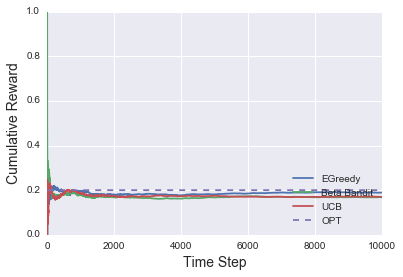

In [184]:
max_payoff = max(sim.arm_probs.values())

plt.plot(np.arange(len(reward_list_1)), np.cumsum(reward_list_1)/np.arange(1,TIME_STEPS+1.0), label = 'EGreedy')

plt.plot(np.arange(len(reward_list_2)), np.cumsum(reward_list_2)/np.arange(1,TIME_STEPS+1.0), label='Beta Bandit')

plt.plot(np.arange(len(reward_list_3)), np.cumsum(reward_list_3)/np.arange(1,TIME_STEPS+1.0), label = 'UCB')

plt.plot(np.arange(TIME_STEPS), np.cumsum([max_payoff]*TIME_STEPS)/ np.arange(1,TIME_STEPS+1.0), label='OPT', ls='--')

plt.legend(loc='lower right')

plt.xlabel("Time Step", fontsize=14)

plt.ylabel("Cumulative Reward", fontsize=14)


In [20]:
np.random.rand()

0.9128317677421505

In [21]:
#plt.hist(sim.arm_probs.values(), 200,None)

[587, 609, 537, 555, 43787, 863, 533, 1166, 523, 840]
[5096, 4998, 4983, 4954, 5053, 4959, 4894, 4999, 5042, 5022]
[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


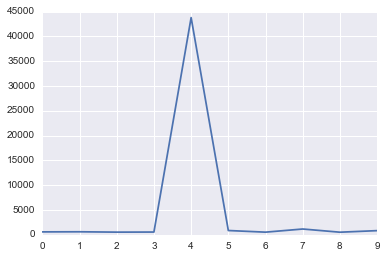

In [22]:
x = range(N_ARMS)
y = played[0]
plt.plot(x,y)
for p in played:
    print p